<a href="https://colab.research.google.com/github/leokan92/class/blob/main/Aula6_redes_neurais_gerativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aula 6 - Redes neurais gerativas

In [ ]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader


## Carregando o MNIST

In [ ]:
# Definindo o dispositivo de hardware (GPU se disponível)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Transformações para os dados de entrada
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Carregando o dataset MNIST
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
data_loader = DataLoader(mnist, batch_size=100, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 33881191.10it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103800937.30it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 17411741.27it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 17972196.95it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Definindo a rede geradora (arquitetura)

In [ ]:
# Definindo o Gerador
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(100, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input).view(-1, 1, 28, 28)

# Definindo o Discriminador
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        input = input.view(-1, 28*28)
        return self.main(input)

## Instanciando função de perda e otimizadores


In [ ]:
# Instanciando o Gerador e o Discriminador
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Otimizadores
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Função de perda
criterion = nn.BCELoss()

## Treinamento da rede

In [ ]:
# Função para criar ruído
def noise(size):
    n = torch.randn(size, 100)
    return n.to(device)

# Treinamento da GAN
num_epochs = 30
for epoch in range(num_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        N = real_batch.size(0)

        # Treinando o Discriminador
        real_data = real_batch.to(device)
        fake_data = generator(noise(N)).detach()
        d_real_decision = discriminator(real_data)
        d_fake_decision = discriminator(fake_data)
        d_real_loss = criterion(d_real_decision, torch.ones(N, 1).to(device))
        d_fake_loss = criterion(d_fake_decision, torch.zeros(N, 1).to(device))

        d_optimizer.zero_grad()
        d_real_loss.backward()
        d_fake_loss.backward()
        d_optimizer.step()

        # Treinando o Gerador
        fake_data = generator(noise(N))
        g_decision = discriminator(fake_data)
        g_loss = criterion(g_decision, torch.ones(N, 1).to(device))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs} Discriminator Loss: {d_real_loss.item()} Generator Loss: {g_loss.item()}')

    # Salvando imagens geradas após a última época
    if (epoch == num_epochs-1):
        save_image(fake_data.view(fake_data.size(0), 1, 28, 28), f'generated_digit_epoch_{epoch}.png')


print('Treinamento concluído')

Epoch 1/30 Discriminator Loss: 0.120456263422966 Generator Loss: 10.457273483276367
Epoch 2/30 Discriminator Loss: 0.12063977122306824 Generator Loss: 3.6400506496429443
Epoch 3/30 Discriminator Loss: 0.41377368569374084 Generator Loss: 1.414211392402649
Epoch 4/30 Discriminator Loss: 0.2432544082403183 Generator Loss: 1.9376534223556519
Epoch 5/30 Discriminator Loss: 0.31836193799972534 Generator Loss: 3.891700267791748
Epoch 6/30 Discriminator Loss: 0.18288375437259674 Generator Loss: 3.8917622566223145
Epoch 7/30 Discriminator Loss: 0.11091281473636627 Generator Loss: 3.0494303703308105
Epoch 8/30 Discriminator Loss: 0.33549928665161133 Generator Loss: 1.783963918685913
Epoch 9/30 Discriminator Loss: 0.20133067667484283 Generator Loss: 2.993497133255005
Epoch 10/30 Discriminator Loss: 0.38886526226997375 Generator Loss: 2.792889356613159
Epoch 11/30 Discriminator Loss: 0.3013026714324951 Generator Loss: 2.378472089767456
Epoch 12/30 Discriminator Loss: 0.31958121061325073 Generator 

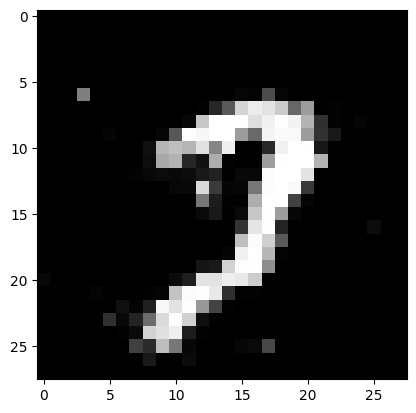

In [ ]:
# Exibindo um dígito gerado
import matplotlib.pyplot as plt
# Exibindo um dígito gerado
fake_data = generator(noise(1)).detach()
fake_data = fake_data.view(fake_data.size(0), 28, 28)
plt.imshow(fake_data.cpu().squeeze(), cmap='gray')
plt.show()